# MAGIC Gamma Telescope Classification Project

### Project Overview

This project implements a deep learning classifier to distinguish between gamma rays (signal) and hadrons (background noise) using data from the MAGIC (Major Atmospheric Gamma Imaging Cherenkov) telescope. The model uses a feed-forward neural network with PyTorch to achieve binary classification.

### Work Distribution

Filip Brutovský (xbrutovskyf@stuba.sk): 50%

Anastasiia Rerikh (xrerikh@stuba.sk): 50%

### **Imports and data fetching**

#### Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import wandb
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import itertools
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from torch.optim import RMSprop

#### **Decision about graph printing**

In [2]:
# User preference for visualization
graphs = input("Print graphs? [y/n]: ").lower() == 'y'

#### Loading the Dataset

In [3]:
# Fetch MAGIC Gamma Telescope dataset from UCI repository
magic_gamma_telescope = fetch_ucirepo(id=159)

# data (as pandas dataframes)
DS_feature = magic_gamma_telescope.data.features
DS_target = magic_gamma_telescope.data.targets

# metadata
print(magic_gamma_telescope.metadata)

# variable information
print(magic_gamma_telescope.variables)



{'uci_id': 159, 'name': 'MAGIC Gamma Telescope', 'repository_url': 'https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope', 'data_url': 'https://archive.ics.uci.edu/static/public/159/data.csv', 'abstract': 'Data are MC generated to simulate registration of high energy gamma particles in an atmospheric Cherenkov telescope', 'area': 'Physics and Chemistry', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 19020, 'num_features': 10, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2004, 'last_updated': 'Tue Dec 19 2023', 'dataset_doi': '10.24432/C52C8B', 'creators': ['R. Bock'], 'intro_paper': None, 'additional_info': {'summary': "The data are MC generated (see below) to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Cherenkov gamm

##### Dataset Information:

* Source: UCI Machine Learning Repository
* Features: 10 continuous attributes derived from telescope image parameters
* Target: Binary classification (gamma vs. hadron)
* Size: ~19,000 instances

### yay

##### Feature Descriptions

1. fLength: Major axis of the ellipse - longest spread of light in the shower image. Indicates shower elongation. [mm]

2. fWidth: Minor axis of the ellipse - width perpendicular to the major axis. [mm]

3. fSize: Logarithmic sum of all pixel intensities (brightness of event). Related to total energy.

4. fConc: Ratio of the two brightest pixels to total intensity - compactness measure.

5. fConc1: Ratio of brightest pixel to total intensity.

6. fAsym: Asymmetry along major axis - offset of light centroid. Indicates directionality. [mm]

7. fM3Long: Third root of third moment along major axis (shape moment). Describes tail shape. [mm]

8. fM3Trans: Third root of third moment along minor axis. [mm]

9. fAlpha: Angle of major axis vs. camera centre line (orientation). Used for source direction. [deg]

10. fDist: Distance from origin (camera centre) to ellipse centre — indicates offset of the shower. [mm]

### **Data exploration**

#### Initial Data Analysis

In [4]:
#data exloration
print(DS_feature.describe())

print("-------------------------------------------------------------")

print(DS_target.describe())


            fLength        fWidth         fSize         fConc        fConc1  \
count  19020.000000  19020.000000  19020.000000  19020.000000  19020.000000   
mean      53.250154     22.180966      2.825017      0.380327      0.214657   
std       42.364855     18.346056      0.472599      0.182813      0.110511   
min        4.283500      0.000000      1.941300      0.013100      0.000300   
25%       24.336000     11.863800      2.477100      0.235800      0.128475   
50%       37.147700     17.139900      2.739600      0.354150      0.196500   
75%       70.122175     24.739475      3.101600      0.503700      0.285225   
max      334.177000    256.382000      5.323300      0.893000      0.675200   

              fAsym       fM3Long      fM3Trans        fAlpha         fDist  
count  19020.000000  19020.000000  19020.000000  19020.000000  19020.000000  
mean      -4.331745     10.545545      0.249726     27.645707    193.818026  
std       59.206062     51.000118     20.827439     26

##### Key Checks:

* Distribution of each feature
* Presence of missing values
* Scale differences between features
* Class balance in target variable

#### Data Preprocessing

##### **Duplicates detection**

In [5]:
print("Duplicates in features:", DS_feature.duplicated().sum())

#DS_feature = DS_feature.drop_duplicates()


Duplicates in features: 115


##### Anomaly Detection

In [6]:
#anomalies detected
def count_anomalies(df, column, normal_min, normal_max):
    mask_normal = (df[column] >= normal_min) & (df[column] <= normal_max)
    anomalies = (~mask_normal).sum()
    return anomalies

print(f"fLength: ", count_anomalies(DS_feature, 'fLength', 0, 1000))
print(f"fWidth: ", count_anomalies(DS_feature, 'fWidth', 0, 1000))
print(f"fSize: ", count_anomalies(DS_feature, 'fSize', 0, 1000))
print(f"fAlpha: ", count_anomalies(DS_feature, 'fAlpha', 0, 180))
print(f"fDist: ", count_anomalies(DS_feature, 'fDist', 0, 1000))


fLength:  0
fWidth:  0
fSize:  0
fAlpha:  0
fDist:  0


##### **Outlier detection and handling**

Theory behind it:
The Interquartile Range (IQR) method identifies outliers as values beyond Q1 - 1.5×IQR or Q3 + 1.5×IQR, where Q1 and Q3 are the 25th and 75th percentiles

In [7]:
features = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


for col in features:
    Q1 = DS_feature[col].quantile(0.25)
    Q3 = DS_feature[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # set outliers to NaN

    DS_feature[col] = DS_feature[col].where(DS_feature[col].between(lower, upper), np.nan)
    #DS_feature.loc[(DS_feature[col] < lower) | (DS_feature[col] > upper), col] = np.nan

C:\Users\filip\AppData\Local\Temp\ipykernel_7980\1481028378.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DS_feature[col] = DS_feature[col].where(DS_feature[col].between(lower, upper), np.nan)
C:\Users\filip\AppData\Local\Temp\ipykernel_7980\1481028378.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DS_feature[col] = DS_feature[col].where(DS_feature[col].between(lower, upper), np.nan)
C:\Users\filip\AppData\Local\Temp\ipykernel_7980\1481028378.py:13: SettingWithCopyWarning: 
A value is trying to

##### Missing Value Imputation

In [8]:

threshold = 30

missing_pct = DS_feature.isna().mean() * 100
to_drop_cols = missing_pct[missing_pct > threshold ].index.tolist()
to_impute_cols = missing_pct[(missing_pct >= 0.1) & (missing_pct <= threshold)].index.tolist()

print(f'Missing percentages:\n{missing_pct}')
print(f'Number of outliers: {(DS_feature.isna().sum().sum())}')

dropped_cols = []
imputed_cols = []

# drop columns with more than 30% (threshold) missing values
for col in to_drop_cols:
    if col in DS_feature.columns:
        DS_feature = DS_feature.drop(columns=[col])
        dropped_cols.append(col)

# for columns with 0.1-30% missing -> impute

for col in to_impute_cols:
    if col not in DS_feature.columns:
        continue
    # checks if the column’s dtype is numeric
    if pd.api.types.is_numeric_dtype(DS_feature[col]):
        median_val = DS_feature[col].median(skipna=True)
        # replaces missing values with the median (less sensetive to outliners than mean)
        # inplace=True means the changes are applied directly to the DataFrame
        DS_feature[col].fillna(median_val, inplace=True)
        imputed_cols.append((col, "median", median_val))
    else:
        # for non-numeric, impute with mode if available
        try:
            mode_val = DS_feature[col].mode(dropna=True)
            if len(mode_val) > 0:
                mode_val = mode_val.iloc[0]
                DS_feature[col].fillna(mode_val, inplace=True)
                imputed_cols.append((col, "mode", mode_val))
            else:
                # if no mode, fill with placeholder
                DS_feature[col].fillna("missing", inplace=True)
                imputed_cols.append((col, "placeholder", "missing"))
        except Exception as e:
            DS_feature[col].fillna("missing", inplace=True)
            imputed_cols.append((col, "placeholder", "missing"))

Missing percentages:
fLength     5.105152
fWidth      8.128286
fSize       1.929548
fConc       0.000000
fConc1      0.788644
fAsym       9.363828
fM3Long     6.403785
fM3Trans    4.468980
fAlpha      0.000000
fDist       0.672976
dtype: float64
Number of outliers: 7011


C:\Users\filip\AppData\Local\Temp\ipykernel_7980\1085086423.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  DS_feature[col].fillna(median_val, inplace=True)
C:\Users\filip\AppData\Local\Temp\ipykernel_7980\1085086423.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DS_feature[col].fillna(median_val, inplace=True)
C:\Users\filip\AppDat

In [9]:
print("Missingness handling summary:")
print(f'Dropped columns (missingness > {threshold}%): {len(dropped_cols)}\n{dropped_cols}')
print(f'Imputed columns (missingness between 5% and {threshold}%): {len(imputed_cols)}\n{imputed_cols}')

Missingness handling summary:
Dropped columns (missingness > 30%): 0
[]
Imputed columns (missingness between 5% and 30%): 8
[('fLength', 'median', np.float64(35.4413)), ('fWidth', 'median', np.float64(16.33535)), ('fSize', 'median', np.float64(2.7292)), ('fConc1', 'median', np.float64(0.1954)), ('fAsym', 'median', np.float64(6.261)), ('fM3Long', 'median', np.float64(16.12725)), ('fM3Trans', 'median', np.float64(0.2081)), ('fDist', 'median', np.float64(191.1745))]


##### Distribution Visualization

QQ Plots assess normality by comparing data quantiles to theoretical normal distribution quantiles.

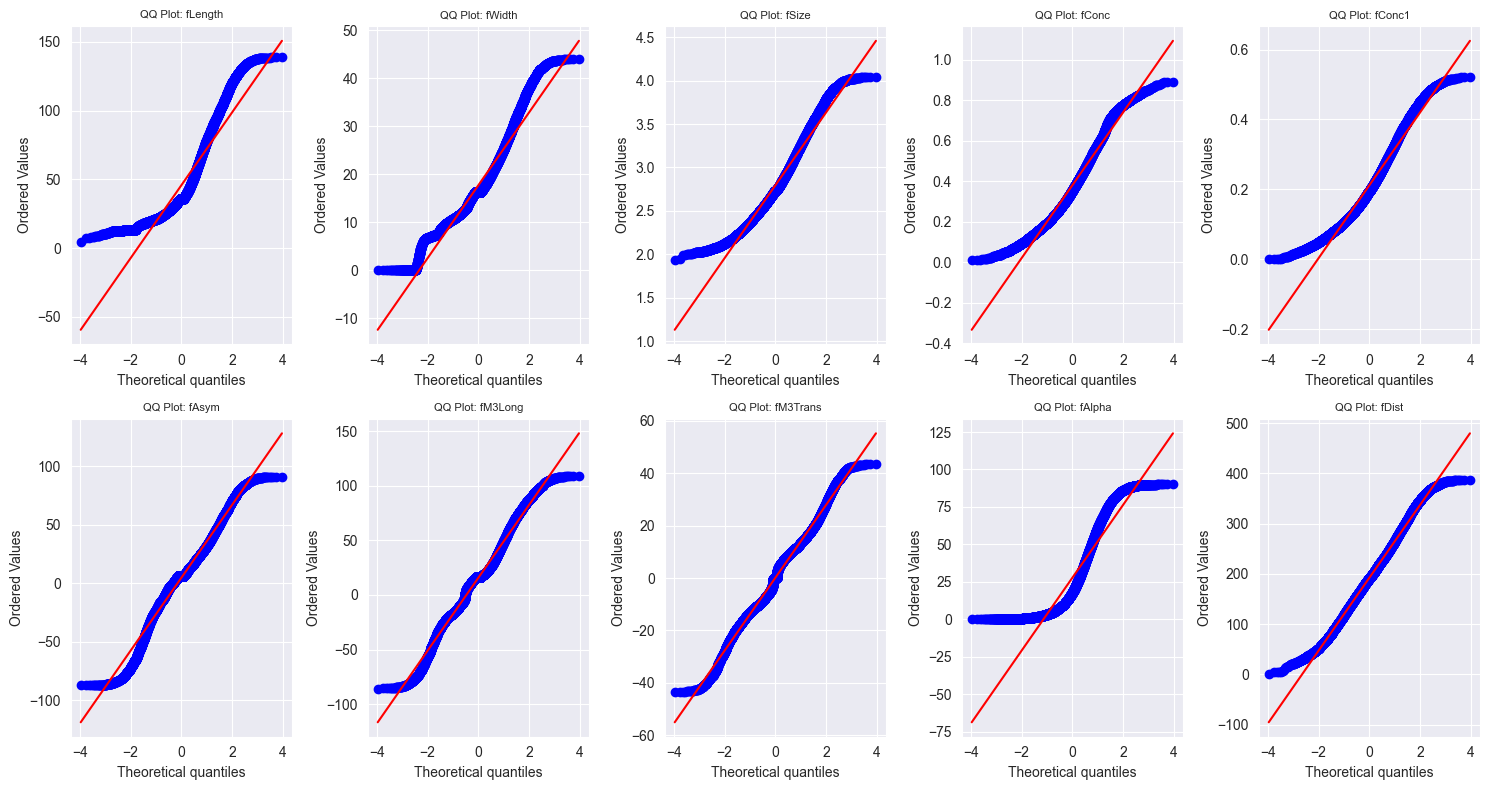

In [10]:
features = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']
if graphs:
    fig, axes = plt.subplots(2, 5, figsize=(15,8))

    for ax, feature in zip(axes.flatten(), features):
        stats.probplot(DS_feature[feature], dist="norm", plot=ax)
        ax.set_title(f"QQ Plot: {feature}", fontsize=8)

    plt.tight_layout()
    plt.show()
else:
    print('no')

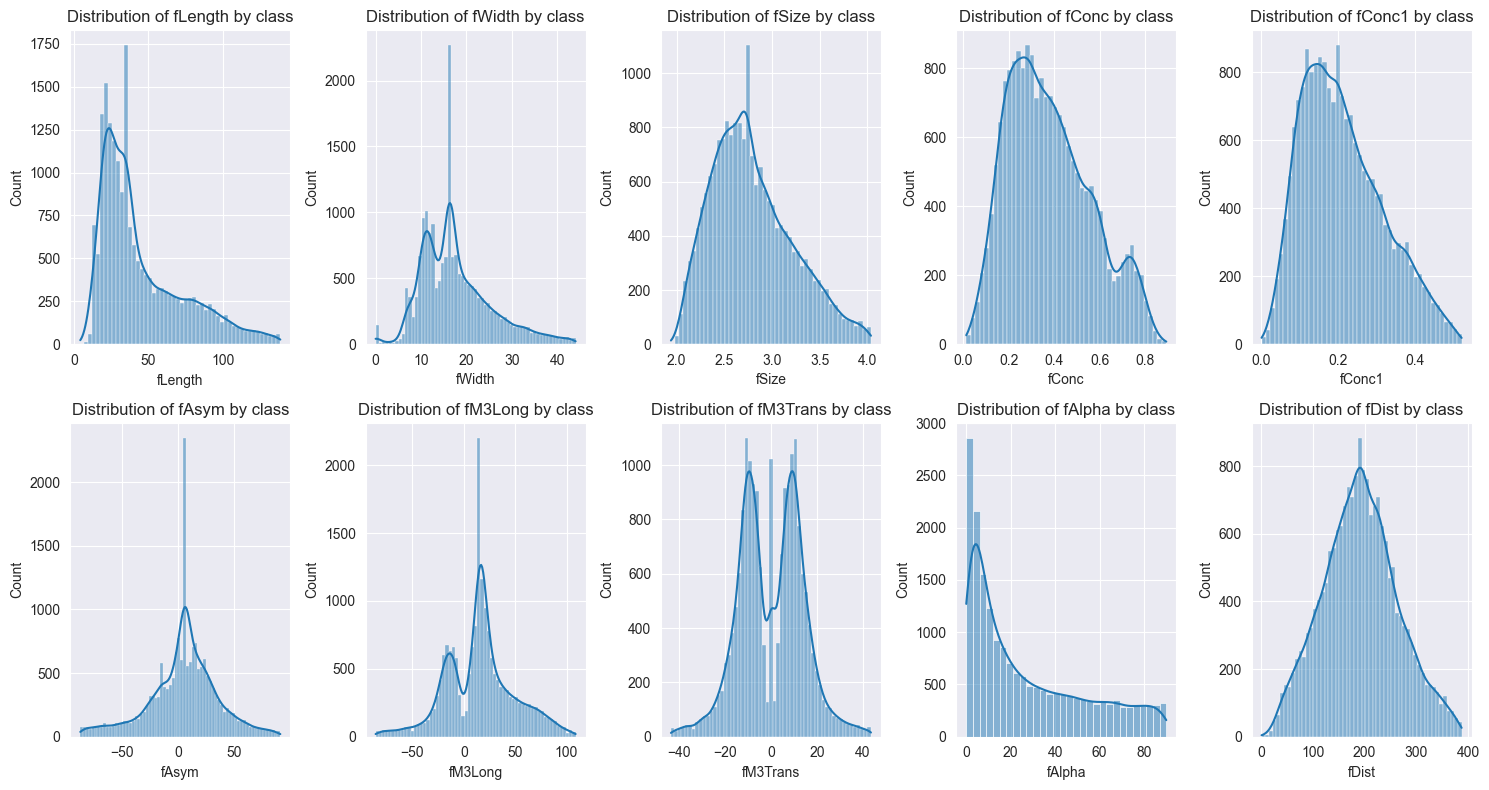

In [11]:
if graphs:
    fig, axes = plt.subplots(2, 5, figsize=(15,8))

    for ax, feature in zip(axes.flatten(), features):
        sns.histplot(DS_feature[feature], kde=True, ax=ax)
        ax.set_title(f"Distribution of {feature} by class")


    plt.tight_layout()
    plt.show()
else:
    print("No plotting, just scheming")

###### **Boxplot for outlier check**

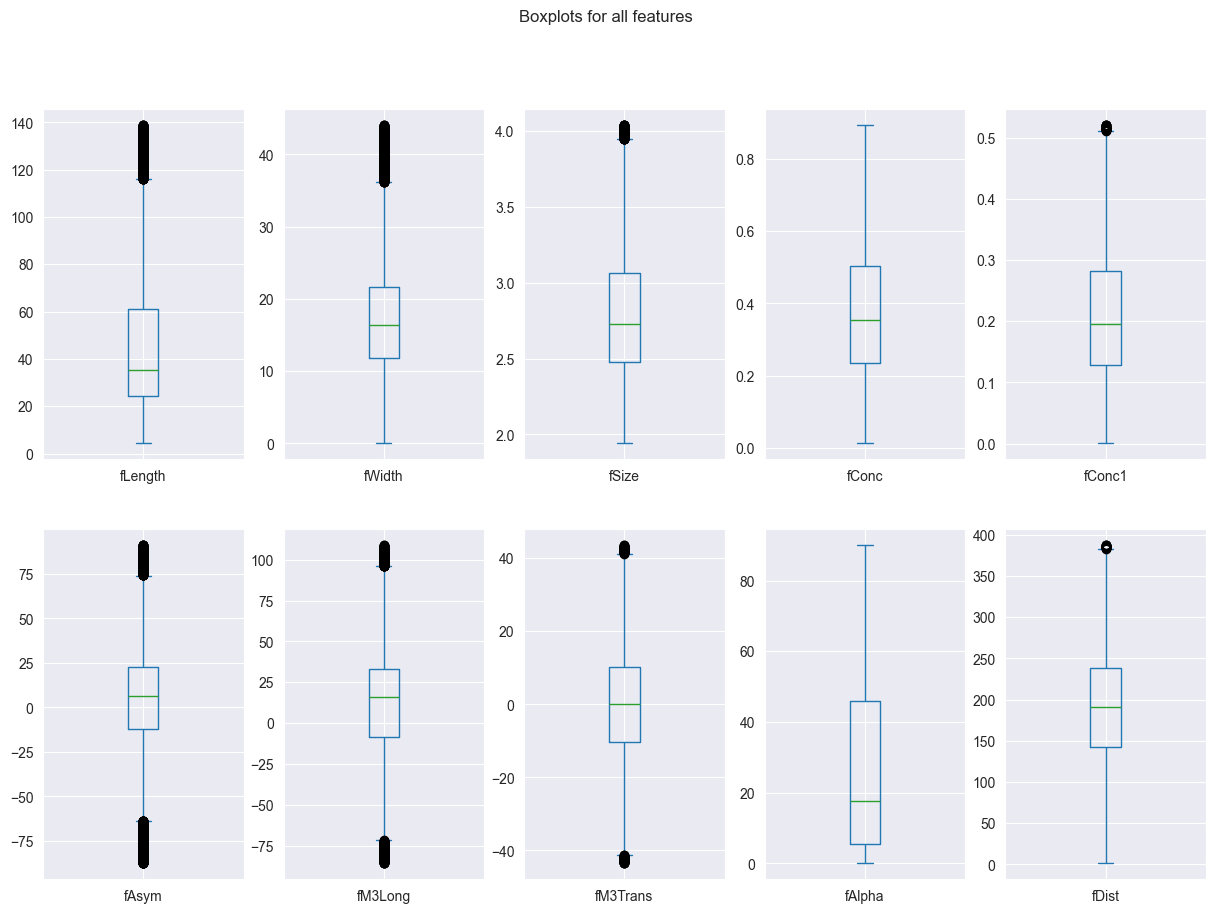

In [12]:
if graphs:
    DS_feature.plot(kind='box', subplots=True,
                                  layout=(2, 5), figsize=(15, 10), sharex=False)
    plt.suptitle("Boxplots for all features")
    plt.show()
else:
    print("EE")

##### Class Distribution Analysis

C:\Users\filip\AppData\Local\Temp\ipykernel_7980\2189859408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DS_target['class'] = DS_target['class'].map({'g': 1, 'h': 0})


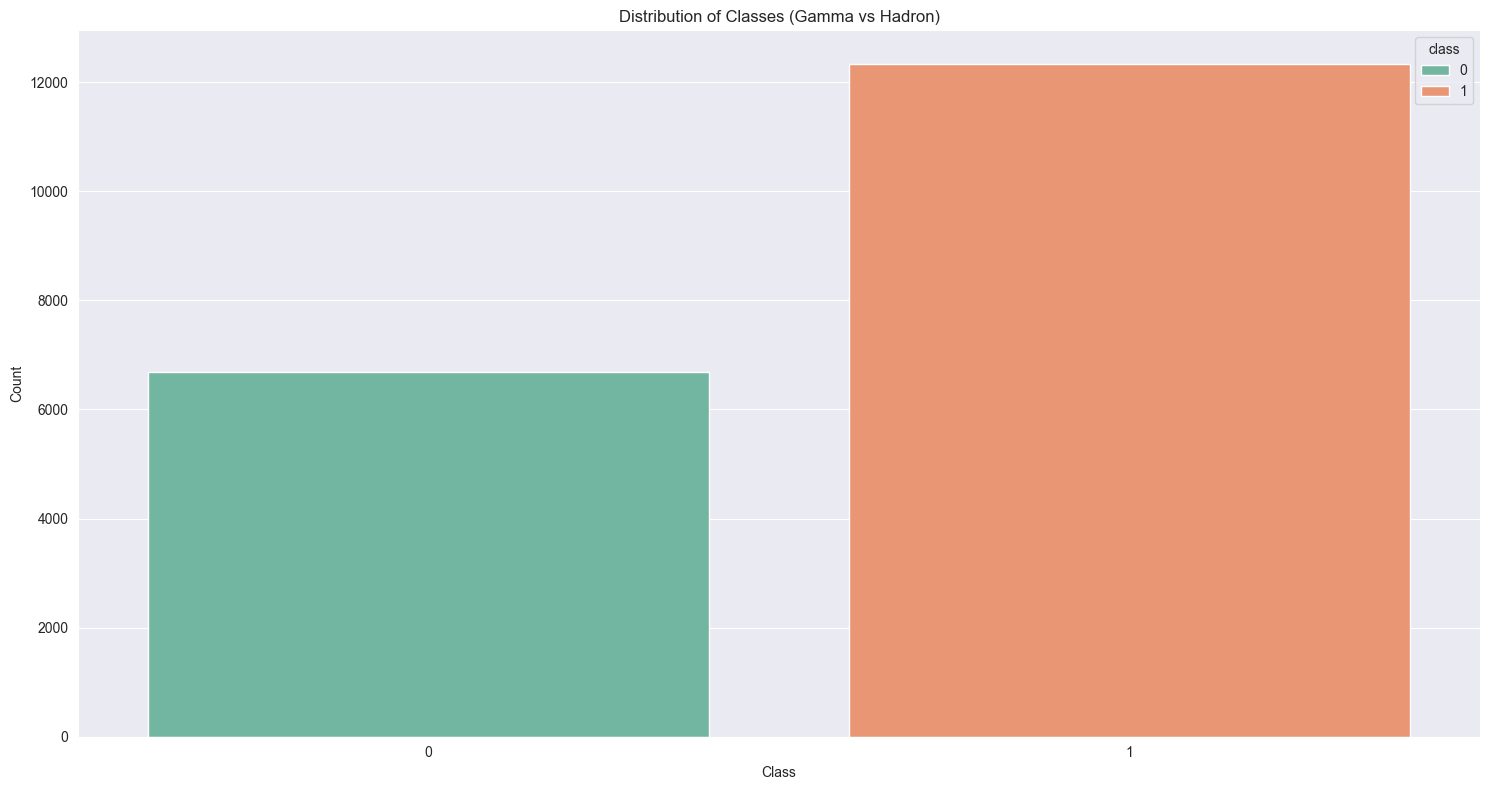

In [13]:
if DS_target['class'].dtype == 'object':
        DS_target['class'] = DS_target['class'].map({'g': 1, 'h': 0})

if graphs:

    plt.figure(figsize=(15, 8))
    sns.countplot(x='class', data=DS_target, palette='Set2', hue='class')
    plt.title("Distribution of Classes (Gamma vs Hadron)")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

else:
    print("nah")

#### Correlation Analysis

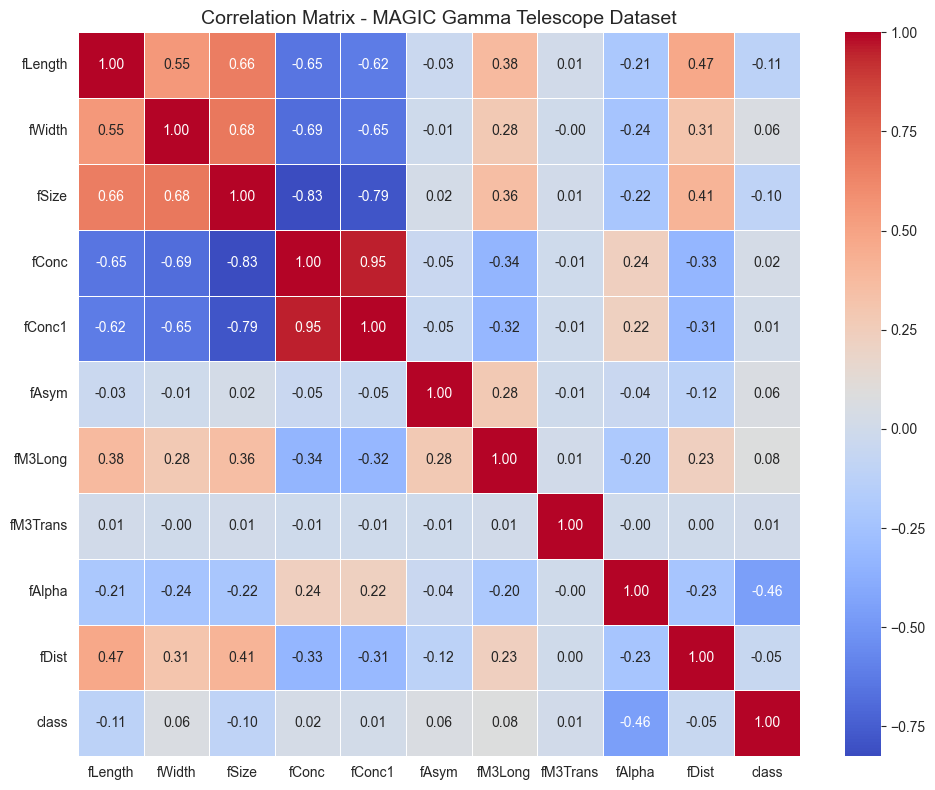

In [14]:
if graphs:
    df = DS_feature.copy()
    df['class'] = DS_target

    df.drop_duplicates()

    if df['class'].dtype == 'object':
        df['class'] = df['class'].map({'g': 1, 'h': 0})

    corr_matrix = df.corr(numeric_only=True)

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrix - MAGIC Gamma Telescope Dataset", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Dont feel like it!")

#### **Data transformation and split**

Power transformations make data more Gaussian-like, which can improve model performance. This transformation works with both positive and negative values.

In [15]:
DS_feature_scaled = DS_feature.copy()

imputer = SimpleImputer(strategy='median')
DS_feature = pd.DataFrame(imputer.fit_transform(DS_feature), columns=DS_feature.columns)

cols_power  = ['fLength', 'fWidth', 'fSize', 'fAlpha','fAsym', 'fM3Long', 'fM3Trans']

pt = PowerTransformer(method='yeo-johnson')

DS_feature_scaled[cols_power] = pt.fit_transform(DS_feature[cols_power])

##### **Post-Transformation Validation**

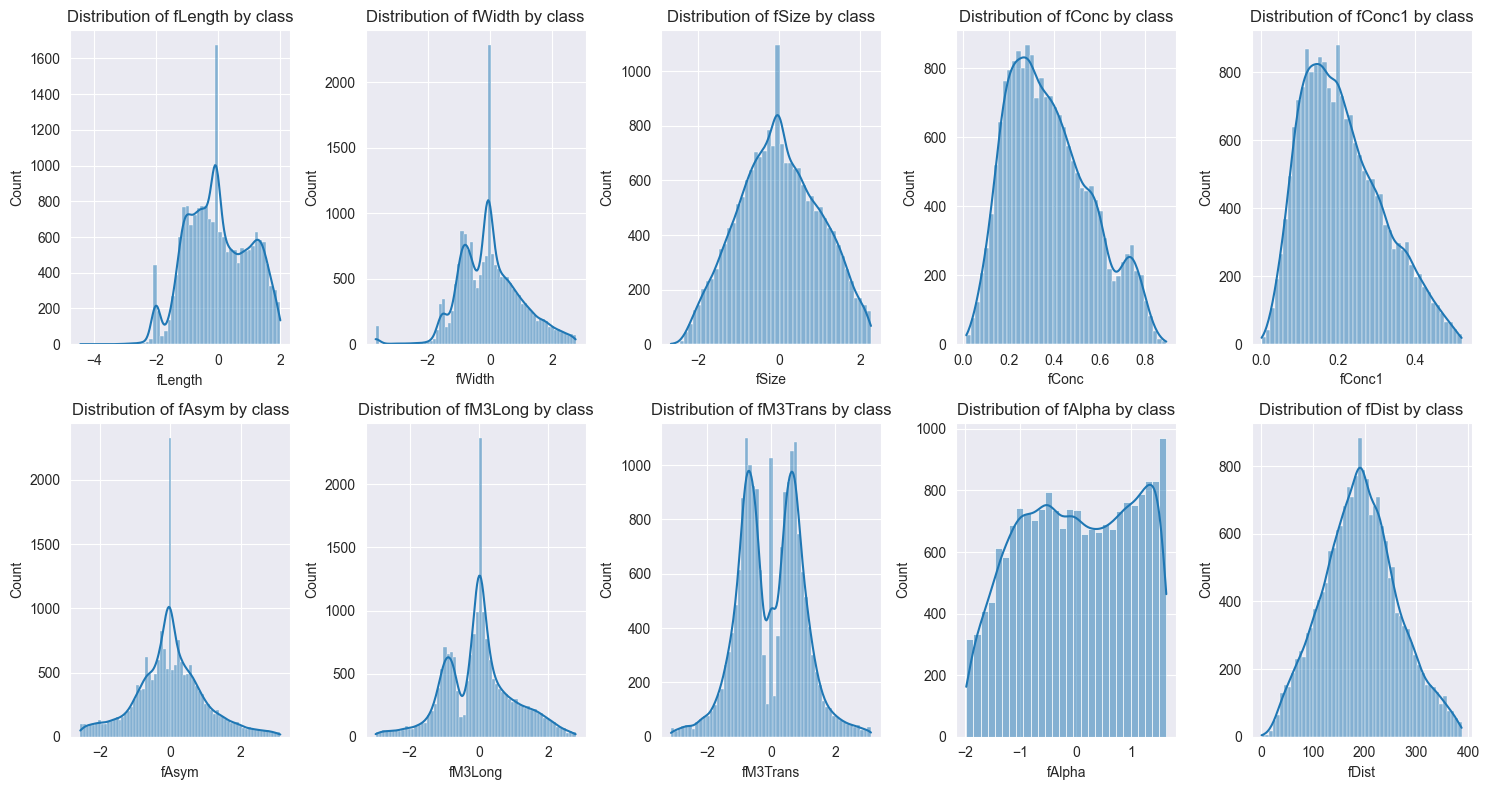

In [16]:
if graphs:
    fig, axes = plt.subplots(2, 5, figsize=(15,8))

    for ax, feature in zip(axes.flatten(), features):
        sns.histplot(DS_feature_scaled[feature], kde=True, ax=ax)
        ax.set_title(f"Distribution of {feature} by class")


    plt.tight_layout()
    plt.show()
else:
    print("Meeh!")

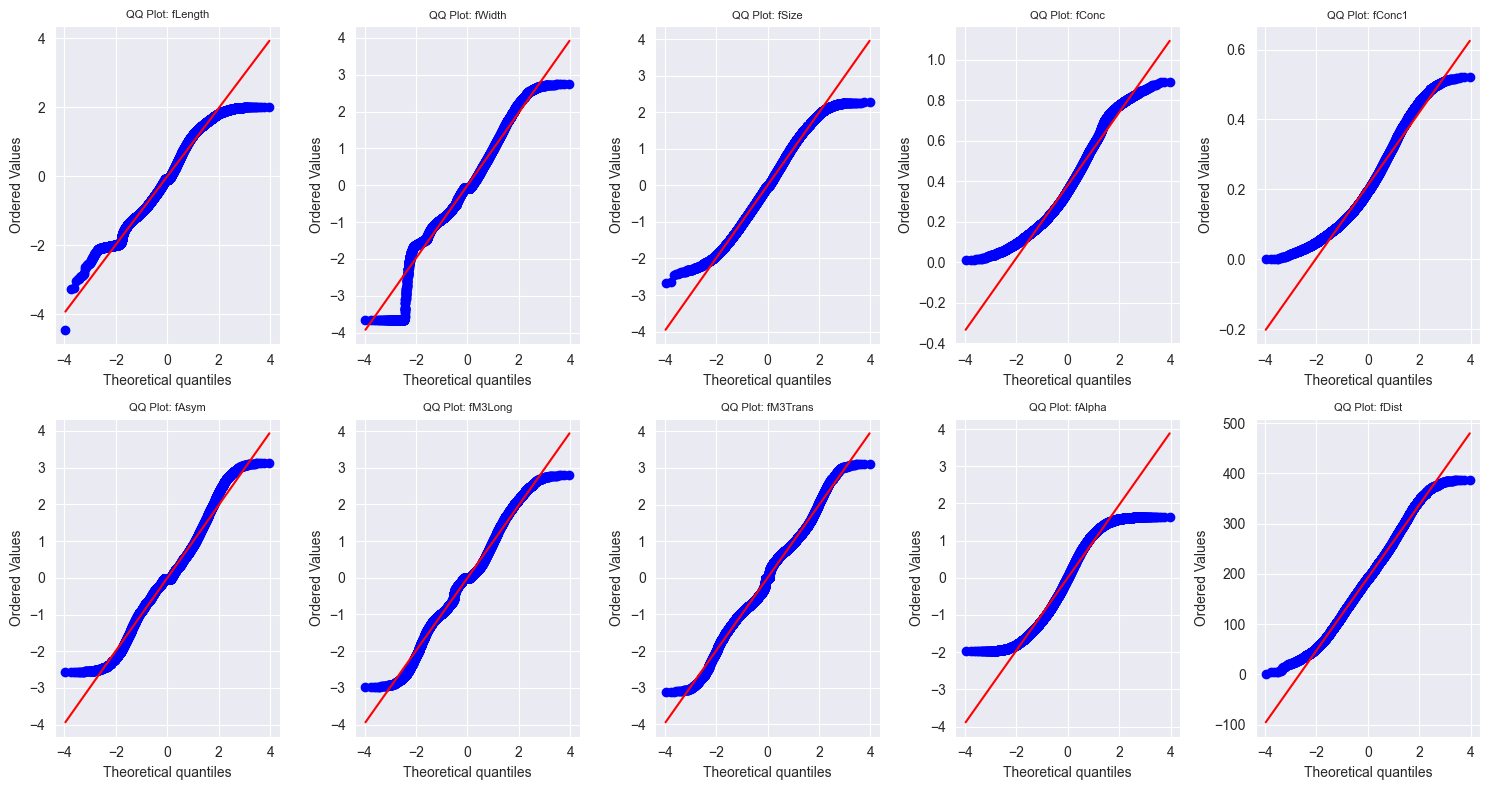

In [17]:
if graphs:
    fig, axes = plt.subplots(2, 5, figsize=(15,8))

    for ax, feature in zip(axes.flatten(), features):
        stats.probplot(DS_feature_scaled[feature], dist="norm", plot=ax)
        ax.set_title(f"QQ Plot: {feature}", fontsize=8)

    plt.tight_layout()
    plt.show()
else:
    print("Think abut the gas prices!")

#### Feature Selection

Feature selection is crucial for several reasons:

1. Reduces Overfitting: Fewer features is less chance of learning noise

2. Improves Interpretability: Easier to understand which features drive predictions

3. Faster Training: Fewer features is faster computation

4. Better Generalization: Models trained on relevant features perform better on unseen data

5. Avoids Multicollinearity: Removes redundant, highly correlated features

##### **Train/Test split**

In [18]:
X = DS_feature_scaled
y = DS_target["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=14, stratify=y
)

**Key Points:**

* 80/20 split: 80% for training, 20% for validation

* Stratified: Maintains the same ratio of gamma/hadron in both sets

* random_state=14: Makes split reproducible (same split every time)

#### **Forward Selection**

**Pseudocode:**

  Start with no features. (R² = 0.20)
  Train model → measure score.
  Try adding each remaining feature one by one.
  Add the feature that gives the best improvement.
  Repeat until no feature improves the score.


In [19]:


remaining_feat = list(features)
selected_feat = []
current_score = 0.0
best_new_score = 0.0

progress = []

while remaining_feat:
    score_with_candidates = []

    for candidate in remaining_feat:
        model = LinearRegression()
        model.fit(X_train[selected_feat + [candidate]], y_train)
        score = model.score(X_test[selected_feat + [candidate]], y_test)
        score_with_candidates.append((score, candidate))

    score_with_candidates.sort()
    best_new_score, best_candidate = score_with_candidates.pop()

    if current_score < best_new_score:
        remaining_feat.remove(best_candidate)
        selected_feat.append(best_candidate)
        current_score = best_new_score
        # print(f"Adding {best_candidate} with score {current_score}")

        progress.append((len(selected_feat), best_candidate, current_score))

    else:
        break

print(f"Forward Selection Result: {selected_feat};")
print(f"Number of Selected Features: {len(selected_feat)};")
print(f"Final Validation Score: {current_score:.4f}")


Forward Selection Result: ['fAlpha', 'fSize', 'fWidth', 'fDist', 'fLength', 'fConc', 'fM3Long', 'fConc1', 'fAsym'];
Number of Selected Features: 9;
Final Validation Score: 0.3593


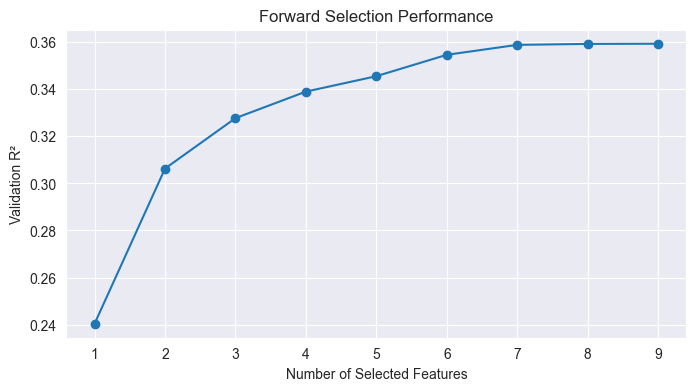

In [20]:
if graphs:
    steps, feats, scores = zip(*progress)
    plt.figure(figsize=(8,4))
    plt.plot(steps, scores, marker='o')
    plt.title("Forward Selection Performance")
    plt.xlabel("Number of Selected Features")
    plt.ylabel("Validation R²")
    plt.grid(True)
    plt.show()
else:
    print("No Forward Selection Result!")

In [21]:
remaining_feat = list(X_train.columns)
current_score = 0.0

model = LinearRegression()
model.fit(X_train[remaining_feat], y_train)
best_score = model.score(X_test[remaining_feat], y_test)

scores_progress = [(len(remaining_feat), best_score)]
print(f"Initial R² with all features: {best_score:.4f}")

Initial R² with all features: 0.3591


##### Pros and Cons of Forward Selection

**Advantages:**

* Simple and intuitive
* Efficient (doesn't test all combinations)
* Works well when most features are irrelevant

**Disadvantages:**

* Greedy (may miss best combination)
* Doesn't reconsider early choices

#### Backward Elimination

**Pseudocode:**

Start with all features. (10 features; R² = 0.3363.)
Train model -> compute baseline score (R²).
For each feature:
    Temporarily remove it -> train the model again.
    Record validation score.
Remove the feature whose removal causes the smallest drop (or largest gain) in score.
Repeat until the score drops or a stopping condition is met.


In [22]:
while len(remaining_feat) > 1:
    scores_with_candidates = []
    
    for feature in remaining_feat:
        reduced_features = [f for f in remaining_feat if f != feature]
        model = LinearRegression()
        model.fit(X_train[reduced_features], y_train)
        score = model.score(X_test[reduced_features], y_test)
        scores_with_candidates.append((score, feature))
    
    scores_with_candidates.sort(reverse=True)
    best_new_score, worst_feature = scores_with_candidates[0]

    if best_new_score < best_score - 0.001:
        break

    remaining_feat.remove(worst_feature)
    best_score = max(best_new_score, best_score)
    scores_progress.append((len(remaining_feat), best_new_score))
    print(f"Removed {worst_feature}, new R²: {best_new_score:.4f}")

print("Backward Elimination Result:")
print(f"Selected features: {remaining_feat};")
print(f"Number of selected features: {len(remaining_feat)}")
print(f"Final Validation R²: {best_score:.4f}")

Removed fM3Trans, new R²: 0.3593
Removed fAsym, new R²: 0.3593
Removed fConc1, new R²: 0.3589
Backward Elimination Result:
Selected features: ['fLength', 'fWidth', 'fSize', 'fConc', 'fM3Long', 'fAlpha', 'fDist'];
Number of selected features: 7
Final Validation R²: 0.3593


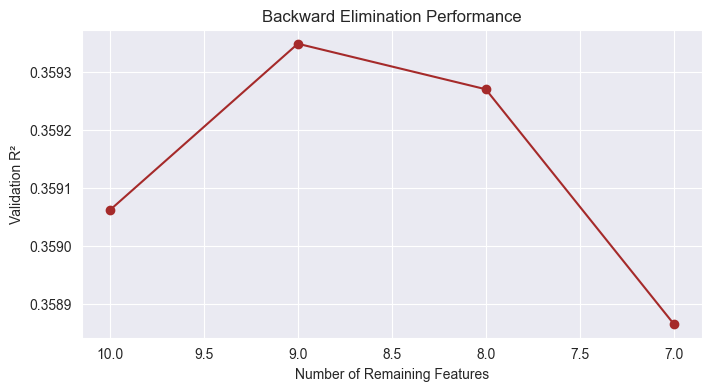

In [23]:
if graphs:
    steps, scores = zip(*scores_progress)
    plt.figure(figsize=(8,4))
    plt.plot(steps, scores, marker="o", linestyle="-", color="brown")
    plt.title("Backward Elimination Performance")
    plt.xlabel("Number of Remaining Features")
    plt.ylabel("Validation R²")
    plt.gca().invert_xaxis()
    plt.grid(True)
    plt.show()
else:
    print("Nothing to do!")

##### Pros and Cons of Backward Elimination

**Advantages:**

* Considers feature interactions (features working together)
* Often finds better combinations than forward selection
* More robust when features are correlated

**Disadvantages:**

* Computationally expensive (starts with all features)
* Can be slow with many features
* May overfit if dataset is small

#### Training Strategies

In [24]:
#choose what to run
run = int(input(
    "Run config (enter number): "
    "[0] default training; [1] early stopping; [2] grid search; [3] grid + early stopping\n"
))

##### Configuration Parameters

In [25]:
#single run params

test_split = 0.2
batch_size = 512
random_state = 14

in_features = None # later int the following cells is split where it sets in features auto (no need 2 set)


learning_rate = 1e-3
epochs = 500
dropout_rate = 0.2
weight_decay = 1e-4
pos = 1.8


In [26]:
# grid search config

config = {
    "lr": [0.001, 5e-4],
    "hidden_dim": [64, 128],
    "dropout_p": [0.05, 0.1],
    "epochs": [10],
    "batch_size": [256, 512],
    "weight_decay": [1e-5, 1e-3],
    "pos_weight": [1,0.8,2]
}

# early stopping settings

monitor = "accuracy"
mode = "max"
patience = 50 # epochs
best_metric = -float("inf") if mode == "max" else float("inf")
wait = 0

# best model path for later possibility of loading it back

best_model_path = "best_model.pt"


#### **Feature setting and final split**

In [27]:
T_features = DS_feature[['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fAlpha', 'fDist']].values
T_labels = DS_target['class'].values

in_features = T_features.shape[1] #here is the in feature set from above initialization


X_train, X_val, y_train, y_val = train_test_split(
    T_features, T_labels, test_size=test_split, random_state=random_state
)


X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)


train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)


#### **Loading data**

In [28]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

#### Model Architecture

##### Neural Network Design: MagicalNet

In [29]:
class MagicalNet(nn.Module):

    """
    Feed-forward neural network for binary classification

    Architecture:
    - Input layer → Hidden layer 1 (128 neurons)
    - BatchNorm → LeakyReLU → Dropout
    - Hidden layer 2 (64 neurons)
    - BatchNorm → LeakyReLU → Dropout
    - Output layer (1 neuron)
    """

    def __init__(self, in_dim, hidden_dim=128, dropout_p=dropout_rate):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.drop1 = nn.Dropout(dropout_p)

        self.fc2 = nn.Linear(hidden_dim, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.drop2 = nn.Dropout(dropout_p)

        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        x = self.drop1(x)
        x = F.leaky_relu(self.bn2(self.fc2(x)))
        x = self.drop2(x)
        return self.fc3(x)


**Key Components:**

1. Batch Normalization: Normalizes layer inputs, accelerating training and improving stability
2. LeakyReLU Activation: Allows small negative gradients (prevents "dying ReLU" problem)
3. Dropout: Randomly deactivates neurons during training to prevent overfitting

In [30]:

model = MagicalNet(in_dim=in_features, hidden_dim=64, dropout_p=dropout_rate)

##### Loss Function and Optimizer

In [31]:
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos]))
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.001)

pos_weight: Increases penalty for misclassifying the minority class (gamma rays)

Experiment tracking with weight and bias.

In [32]:
wandb.login()

wandb: Currently logged in as: awefilko (awefilko-fiit-stu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [33]:
if run == 0 or run == 1:
    wandb.init(project="ZNEUS_R&B", name="gamma_classification",
        config={
            "epochs": epochs,
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "dropout_p": dropout_rate,
            "in_features": in_features,
            "weight_decay": weight_decay,
            "architecture": "MagicalNet"
        })

In [34]:
if run == 0:
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for xb, yb in train_loader:
            xb, yb = xb, yb.unsqueeze(1)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)

        epoch_loss = running_loss / len(val_loader.dataset)
        #scheduler.step()
        #print(f"Current LR: {optimizer.param_groups[0]['lr']}")
        wandb.log({"train_loss": epoch_loss, "epoch": epoch + 1})

        print(f"Epoch {epoch+1}/{epochs} — loss: {epoch_loss:.4f}")
else:
    print("Not me!")

Epoch 1/500 — loss: 3.1853
Epoch 2/500 — loss: 2.4929
Epoch 3/500 — loss: 2.3603
Epoch 4/500 — loss: 2.3051
Epoch 5/500 — loss: 2.2885
Epoch 6/500 — loss: 2.2628
Epoch 7/500 — loss: 2.2232
Epoch 8/500 — loss: 2.2265
Epoch 9/500 — loss: 2.2046
Epoch 10/500 — loss: 2.1916
Epoch 11/500 — loss: 2.1617
Epoch 12/500 — loss: 2.1534
Epoch 13/500 — loss: 2.1433
Epoch 14/500 — loss: 2.1314
Epoch 15/500 — loss: 2.1102
Epoch 16/500 — loss: 2.1219
Epoch 17/500 — loss: 2.1161
Epoch 18/500 — loss: 2.0945
Epoch 19/500 — loss: 2.0841
Epoch 20/500 — loss: 2.0788
Epoch 21/500 — loss: 2.0700
Epoch 22/500 — loss: 2.0756
Epoch 23/500 — loss: 2.0648
Epoch 24/500 — loss: 2.0657
Epoch 25/500 — loss: 2.0629
Epoch 26/500 — loss: 2.0505
Epoch 27/500 — loss: 2.0190
Epoch 28/500 — loss: 1.9987
Epoch 29/500 — loss: 1.9705
Epoch 30/500 — loss: 1.9434
Epoch 31/500 — loss: 1.9309
Epoch 32/500 — loss: 1.9093
Epoch 33/500 — loss: 1.9377
Epoch 34/500 — loss: 1.9186
Epoch 35/500 — loss: 1.9170
Epoch 36/500 — loss: 1.9102
E

#### Training Modes

##### Basic Training

Standard training loop with fixed epochs.

In [35]:
if run == 0:
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()
            all_preds.append(preds.cpu())
            all_targets.append(yb.unsqueeze(1).long())

    all_preds = torch.cat(all_preds).squeeze().numpy()
    all_targets = torch.cat(all_targets).squeeze().numpy()
    accuracy = (all_preds == all_targets).mean()

    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    cm = confusion_matrix(all_targets, all_preds)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("Confusion matrix:\n", cm)

    wandb.log({
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion matrix": cm,
    })
else:
    print("Not me either!")


Accuracy: 0.8696
Precision: 0.8475
Recall: 0.9789
F1-score: 0.9085
Confusion matrix:
 [[ 846  443]
 [  53 2462]]


##### Early Stopping

Stops training when validation metric stops improving, preventing overfitting.

In [36]:
if run == 1:
    for epoch in range(epochs):

        # -------- training --------

        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb, yb.unsqueeze(1)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)

        #scheduler.step()
        train_epoch_loss = running_loss / len(train_loader.dataset)
        wandb.log({"train_loss": train_epoch_loss, "epoch": epoch + 1})
        #print(f"Current LR: {optimizer.param_groups[0]['lr']}")

        # -------- validation / evaluation --------

        model.eval()
        probs_list = []
        targets_list = []
        with torch.no_grad():
            for xb, yb in val_loader:
                logits = model(xb)
                probs = torch.sigmoid(logits).cpu().numpy().squeeze()
                probs_list.append(probs)
                targets_list.append(yb.numpy().squeeze())

        all_probs = np.concatenate(probs_list)
        all_targets = np.concatenate(targets_list)
        all_preds = (all_probs > 0.5).astype(int)

        # compute metrics
        accuracy = (all_preds == all_targets).mean()
        precision = precision_score(all_targets, all_preds, zero_division=0)
        recall = recall_score(all_targets, all_preds, zero_division=0)
        f1 = f1_score(all_targets, all_preds, zero_division=0)
        cm = confusion_matrix(all_targets, all_preds)

        print(f"Epoch {epoch+1}/{epochs} — train_loss: {train_epoch_loss:.4f}  val_f1: {f1:.4f}")
        print(f"Acc: {accuracy:.4f}, Prec: {precision:.4f}, Rec: {recall:.4f}")
        print("Confusion matrix:\n", cm)

        wandb.log({
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "confusion matrix": cm,
        })

        # -------- early stopping logic --------

        if monitor == "f1":
            current = f1
        elif monitor == "precision":
            current = precision
        elif monitor == "recall":
            current = recall
        elif monitor == "accuracy":
            current = accuracy
        else:
            raise ValueError("Unknown monitor metric")

        improved = (current > best_metric) if mode == "max" else (current < best_metric)
        if improved:
            best_metric = current
            wait = 0
            torch.save(model.state_dict(), best_model_path)   # save best weights
            print(f"  New best {monitor}: {best_metric:.4f}. Saved model.")
        else:
            wait += 1
            print(f"  No improvement for {wait} epoch(s).")

        if wait >= patience:
            print("Early stopping triggered. Restoring best model.")
            break


    model.load_state_dict(torch.load(best_model_path))

    model.load_state_dict(torch.load(best_model_path))
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()
            all_preds.append(preds.cpu())
            all_targets.append(yb.unsqueeze(1).cpu())

    # Convert to numpy arrays
    all_preds = torch.cat(all_preds).squeeze().numpy()
    all_targets = torch.cat(all_targets).squeeze().numpy()

    # --- Compute metrics ---
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    cm = confusion_matrix(all_targets, all_preds)

    # --- Print results ---
    print("Best Model Validation Metrics:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
else:
    print("Nothing to do.")


Nothing to do.


##### Grid Search

Systematically tests hyperparameter combinations.

In [37]:
if run == 2:
    # --- Create all possible combinations
    param_combinations = list(itertools.product(*config.values()))

    # --- Iterate through all combinations
    for combo in param_combinations:
        params = dict(zip(config.keys(), combo))
        print(f"\nRunning grid search with params: {params}")

        wandb.init(project="ZNEUS_R&B", config=params, name="GC_grid_search")
        config = wandb.config

        train_loader = DataLoader(train_ds, batch_size= config.batch_size, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size= config.batch_size, shuffle=False)

        model = MagicalNet(in_dim=in_features, hidden_dim=config.hidden_dim, dropout_p=config.dropout_p)
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([config.pos_weight]))
        optimizer = optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

        # --- Training loop (your original)
        for epoch in range(config.epochs):
            model.train()
            running_loss = 0.0

            for xb, yb in train_loader:
                xb, yb = xb, yb.unsqueeze(1)
                optimizer.zero_grad()
                logits = model(xb)
                loss = criterion(logits, yb)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * xb.size(0)

            epoch_loss = running_loss / len(train_loader.dataset)
            wandb.log({"train_loss": epoch_loss, "epoch": epoch + 1})
            #print(f"Epoch {epoch+1}/{config.epochs} — loss: {epoch_loss:.4f}")

        # --- Validation accuracy check
        model.eval()
        probs_list = []
        targets_list = []

        with torch.no_grad():
            for xb, yb in val_loader:
                logits = model(xb)
                probs = torch.sigmoid(logits).cpu().numpy().squeeze()
                probs_list.append(probs)
                targets_list.append(yb.numpy().squeeze())

        all_probs = np.concatenate(probs_list)
        all_targets = np.concatenate(targets_list).astype(int)
        all_preds = (all_probs > 0.5).astype(int)

        accuracy = accuracy_score(all_targets, all_preds)
        precision = precision_score(all_targets, all_preds)
        recall = recall_score(all_targets, all_preds)
        f1 = f1_score(all_targets, all_preds)
        cm = confusion_matrix(all_targets, all_preds)

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        #print("Confusion matrix:\n", cm)

        wandb.log({
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "confusion_matrix": cm,
        })
else:
    print("No grid search.\n"
          " 🥺\n"
          "👉👈\n")

No grid search.
 🥺
👉👈



##### Grid Search + Early Stopping

In [38]:
if run == 3:
    # --- Hyperparameter grid
    param_combinations = list(itertools.product(*config.values()))


    # --- Grid search
    for combo in param_combinations:
        params = dict(zip(config.keys(), combo))
        print(f"\nRunning grid search with params: {params}")


        run = wandb.init(project="ZNEUS_R&B",name = "GC_Grid_search_w_es", config=params, reinit=True)
        config = wandb.config

        train_loader = DataLoader(train_ds, batch_size= config.batch_size, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size= config.batch_size, shuffle=False)

        # build model / criterion / optimizer
        model = MagicalNet(in_dim=in_features, hidden_dim=config.hidden_dim, dropout_p=config.dropout_p)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

        # early stopping state
        best_epoch = -1
        best_metrics = None

        # training + validation per epoch (so we can early-stop)
        for epoch in range(config.epochs):
            # -------- training --------
            model.train()
            running_loss = 0.0
            for xb, yb in train_loader:
                xb, yb = xb, yb.unsqueeze(1)
                optimizer.zero_grad()
                logits = model(xb)
                loss = criterion(logits, yb)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * xb.size(0)

            train_epoch_loss = running_loss / len(train_loader.dataset)

            # -------- validation --------
            model.eval()
            probs_list = []
            targets_list = []
            with torch.no_grad():
                for xb, yb in val_loader:
                    logits = model(xb)
                    probs = torch.sigmoid(logits).cpu().numpy().squeeze()
                    probs_list.append(probs)
                    targets_list.append(yb.numpy().squeeze())

            all_probs = np.concatenate(probs_list)
            all_targets = np.concatenate(targets_list).astype(int)
            all_preds = (all_probs > 0.5).astype(int)

            # compute metrics
            prec = precision_score(all_targets, all_preds, zero_division=0)
            rec = recall_score(all_targets, all_preds, zero_division=0)
            f1 = f1_score(all_targets, all_preds, zero_division=0)
            acc = accuracy_score(all_targets, all_preds)
            cm = confusion_matrix(all_targets, all_preds)

            if monitor == "f1":
                current = f1
            elif monitor == "precision":
                current = prec
            elif monitor == "recall":
                current = rec
            elif monitor == "accuracy":
                current = acc
            else:
                raise ValueError(f"Unknown monitor metric: {monitor}")

            # logging
            wandb.log({
                "train_loss": train_epoch_loss,
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "f1_score": f1,
                "epoch": epoch + 1
            })

            print(f"Epoch {epoch+1}/{config.epochs} — train_loss: {train_epoch_loss:.4f}  val_f1: {f1:.4f}")

            # early stopping decision
            improved = (current > best_metric) if mode == "max" else (current < best_metric)
            if improved:
                best_metric = current
                wait = 0
                best_epoch = epoch + 1
                best_metrics = {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "confusion_matrix": cm}
                torch.save(model.state_dict(), best_model_path)
                print(f"  New best {monitor}: {best_metric:.4f} (saved)")
            else:
                wait += 1
                print(f"  No improvement for {wait} epoch(s) (patience={patience})")

            if wait >= patience:
                print("Early stopping triggered.")
                break

        if best_metrics is not None:
            model.load_state_dict(torch.load(best_model_path, map_location="cpu"))
            model.eval()

            probs_list = []
            targets_list = []
            with torch.no_grad():
                for xb, yb in val_loader:
                    logits = model(xb)
                    probs = torch.sigmoid(logits).cpu().numpy().squeeze()
                    probs_list.append(probs)
                    targets_list.append(yb.numpy().squeeze())

            all_probs = np.concatenate(probs_list)
            all_targets = np.concatenate(targets_list).astype(int)
            all_preds = (all_probs > 0.5).astype(int)

            prec = precision_score(all_targets, all_preds, zero_division=0)
            rec = recall_score(all_targets, all_preds, zero_division=0)
            f1 = f1_score(all_targets, all_preds, zero_division=0)
            acc = accuracy_score(all_targets, all_preds)
            cm = confusion_matrix(all_targets, all_preds)

            # log final best-run metrics
            wandb.log({
                "best_val_accuracy": acc,
                "best_val_precision": prec,
                "best_val_recall": rec,
                "best_val_f1": f1
            })
            print("BEST validation metrics (loaded best model):")
            print(f"Accuracy:  {acc:.4f}")
            print(f"Precision: {prec:.4f}")
            print(f"Recall:    {rec:.4f}")
            print(f"F1-score:  {f1:.4f}")
            print("Confusion matrix:\n", cm)
        else:
            print("No improvement recorded during run; no best model saved.")
else:
    print("Why am I here?. Just to suffer!")



Why am I here?. Just to suffer!


**Interpretation:**

* True Negatives (TN): x hadrons correctly classified
* False Positives (FP): x hadrons misclassified as gamma
* False Negatives (FN): x gammas misclassified as hadron
* True Positives (TP): x gammas correctly classified

In [39]:
wandb.finish()

accuracy,▁
epoch,▁▁▁▁▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
f1_score,▁
precision,▁
recall,▁
train_loss,█▇▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.86961
epoch,500
f1_score,0.90849
precision,0.8475
recall,0.97893


### Experimental conclusion

   Throughout model development, several improvements and techniques were tested to enhance performance. Weighted loss (pos_weight) was adjusted to account for class imbalance, improving the balance between precision and recall. Normalisation layers stabilised training and accelerated convergence, while dropout, when applied, improved performance; without it NN had problems with generalisation. Early stopping was effective in catching unstable learning progress. Among activation functions, Leaky ReLU outperformed Tanh and ReLU by preventing dead neurons and maintaining stable gradient flow. Learning rate scheduling, however, did not provide additional benefits in this setup. Taken together, these experiments demonstrate that careful handling of class imbalance, normalisation, and activation selection had the most significant positive impact on model performance.


In [40]:
# model = MagicalNet(in_dim=in_features, hidden_dim=64)
#
# # Load the saved weights
# model.load_state_dict(torch.load('model_87.pt'))
# model.eval()
#
# # Example input — your real data goes here
# new_input = [[1.46773678e+00, 2.22794825e+00 , 2.22794825e+00 , 1.68000000e-01, 1.01100000e-01,
#               1.68377205e+00, 2.20081444e+005, -1.79772516e-01, 2.31902800e+02]]
#
# # Convert to tensor
# x = torch.tensor(new_input, dtype=torch.float32)
#
#
# with torch.no_grad():
#     logit = model(x)
#     prob = torch.sigmoid(logit).item()      # convert to probability
#     pred = int(prob > 0.5)
#
# if pred == 1:
#     print(f"Prediction: Class 1 (probability: {prob:.3f})")
# else:
#     print(f"Prediction: Class 0 (probability: {prob:.3f})")

In [41]:
# idx = DS_target[DS_target['class'] == 0].index[0]
#
# feature_row = DS_feature_scaled.loc[idx, ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fAlpha', 'fDist']]
# target_val = DS_target.loc[idx, 'class']
#
# print("Features:", feature_row.values)
# print("Target:", target_val)
